In [36]:
import cv2
import matplotlib.pyplot as plt
import math
from skimage.metrics import structural_similarity
import numpy as np


In [2]:
img = cv2.imread('BROWNSPOT1_092.jpg')

In [3]:
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


In [24]:
new_img = cv2.GaussianBlur(img_rgb,(7,7),0)

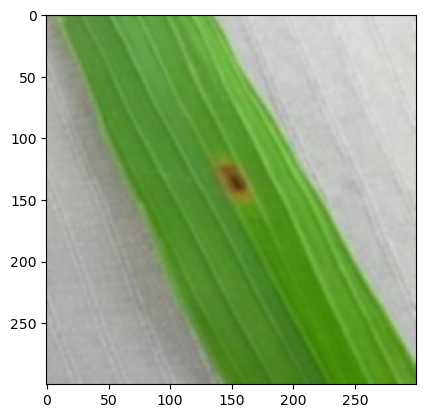

In [25]:
plt.imshow(new_img)

In [27]:
mse = ((img_rgb.flatten()-new_img.flatten())**2).mean()

In [28]:
mse

54.39247407407407

In [29]:
psnr = 10 * math.log10(255**2/mse)

In [30]:
psnr

30.775415474603285

In [44]:
structural_similarity(img_rgb,new_img,data_range=img_rgb.max()-img_rgb.min(),channel_axis=2)

0.5989727654007014